<a href="https://colab.research.google.com/github/gopichandchalla16/infosys-internship-real-time-industry-insight-system/blob/anshika-dev/Project_Sprint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Infosys Springboard Internship — Sprint 1

**Purpose:** notebook that fetches market & news data, synthesizes/ingests tweet-like text, runs sentiment analysis (FinBERT + lightweight fallback), and visualizes sentiment vs price trends.

**Team Members:**<br>
Anshika Gupta<br>
Gopichand<br>
Janmejay Singh<br>
Vaishnavi<br>

<!-- Colab badge: opens this notebook in Google Colab -->
<a href="https://colab.research.google.com/github/gopichandchalla16/infosys-internship-real-time-industry-insight-system/blob/main/Project_Sprint1.ipynb" target="_blank">
  <img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

**Quick run**
- **In Google Colab**: click the badge above and run the notebook cells in order (or: `Runtime → Run all`).

**Required environment variables / API keys**
- `ALPHA_VANTAGE_API` — Alpha Vantage API key (for market prices).
- Optional: `SLACK_WEBHOOK_URL` — (for Slack alerts).
Set these either as environment variables or (in Colab) via `google.colab.userdata.set()`.

**Notes & warnings**
- The notebook may download large models (e.g., `ProsusAI/finbert`). This can be slow on CPU and will use significant bandwidth and disk space. A GPU runtime is **recommended** for FinBERT inference.


## Project Overview

This notebook is developed as part of the **Infosys Springboard Internship ** and demonstrates a complete **financial sentiment analysis pipeline** using real-world market and news data.

### 🔹 What this notebook does
1. Accepts a **company name** as user input.
2. Fetches:
   - **Stock market data** from Alpha Vantage / Yahoo Finance
   - **News articles** from Google News RSS
   - **Company description** from Wikipedia
3. Collects or generates **tweet-style financial text**.
4. Performs **sentiment analysis** using:
   - ✅ `ProsusAI/finbert` (finance-specific transformer model)
   - ✅ Lightweight NLP fallback (TextBlob)
5. Produces:
   - 📊 Sentiment distribution plots
   - 📈 Price vs sentiment trend analysis
6. Sends **Slack alerts** based on detected sentiment.

---

### 🔹 Key Outputs Generated
- Processed tweet sentiment (`positive`, `neutral`, `negative`)
- Market trend graph
- Sentiment trend visualization
- Slack notification

---

### ⚠️ Reproducibility Notes
- Internet access is required.
- API keys must be configured before execution.
- Some models require high memory and may run slow on CPU-only systems.



In [49]:
# =========================
# USER INPUT (RESTRICTED TO PREDEFINED LIST)
# =========================

ALLOWED_COMPANIES = {
    "NETFLIX",
    "APPLE",
    "TESLA",
    "GOOGLE",
    "MICROSOFT",
    "TCS",
    "INFOSYS",
    "RAKUTEN",
    "BITCOIN",
    "AMAZON",
    "META",
    "NVIDIA",
    "AMD",
    "INTEL",
    "JP MORGAN",
    "GOLDMAN SACHS",
    "MASTERCARD",
    "VISA",
    "RELIANCE",
    "HDFC",
    "ICICI",
    "WIPRO",
    "HCL",
    "ADANIPORTS",
    "ADANIENT",
    "TATA MOTORS",
    "MARUTI",
    "COCA COLA",
    "PEPSICO",
    "WALMART",
    "ETHEREUM",
    "DOGECOIN",
    "SOLANA"
}

def get_valid_company_name():
    """
    Restricts user input strictly to a predefined list of companies.
    Ignores case and extra spaces.

    Returns:
        str: Validated company name
    """

    print("✅ Please select a company ONLY from the list below:\n")
    for name in (ALLOWED_COMPANIES):
        print("•", name)

    print("\n--------------------------------------")

    while True:
        user_input = input("Enter company name exactly as shown above: ").strip().upper()

        # ❌ Empty input
        if not user_input:
            print("❌ Input cannot be empty. Please select from the provided list.")
            continue

        # ❌ Invalid company
        if user_input not in ALLOWED_COMPANIES:
            print("❌ Invalid selection. Please select from the provided list only.")
            continue

        return user_input.title()


# Collect validated input
company_name = get_valid_company_name()

print(f"\n✅ Selected company for analysis: {company_name}")


✅ Please select a company ONLY from the list below:

• GOLDMAN SACHS
• JP MORGAN
• META
• WIPRO
• NETFLIX
• RAKUTEN
• NVIDIA
• INTEL
• TCS
• ADANIENT
• ETHEREUM
• VISA
• ADANIPORTS
• GOOGLE
• AMAZON
• MARUTI
• PEPSICO
• COCA COLA
• DOGECOIN
• MICROSOFT
• TATA MOTORS
• HCL
• MASTERCARD
• WALMART
• SOLANA
• APPLE
• BITCOIN
• HDFC
• AMD
• INFOSYS
• ICICI
• TESLA
• RELIANCE

--------------------------------------
Enter company name exactly as shown above: microsoft

✅ Selected company for analysis: Microsoft


##  Step 2: Import Required Libraries
We use the following Python libraries:
- `requests` & `BeautifulSoup` for scraping web data
- `pandas` for data manipulation
- `matplotlib` & `seaborn` for visualization
- `textblob` for sentiment analysis
- `yfinance` for market data
- `wikipedia` for Wikipedia summaries


In [50]:
# =========================
# SAFE PACKAGE INSTALLATION & VERIFICATION
# =========================

import sys
import subprocess
import importlib

REQUIRED_PACKAGES = [
    "transformers",
    "torch",
    "yfinance",
    "alpha-vantage",
    "textblob",
    "feedparser",
    "beautifulsoup4",
    "faker",
    "pandas",
    "numpy",
    "matplotlib",
    "wikipedia",
    "requests"
]

def install_if_missing(package):
    try:
        importlib.import_module(package.replace("-", "_"))
        print(f"✅ {package} already installed")
    except ImportError:
        print(f"⏳ Installing {package} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install all required packages
for pkg in REQUIRED_PACKAGES:
    install_if_missing(pkg)

print("\n✅ Package installation complete.")


# 🔥 Hardware & Runtime Warning
try:
    import torch
    if not torch.cuda.is_available():
        print("⚠️ GPU not detected. FinBERT will run slowly on CPU.")
    else:
        print("✅ GPU detected. FinBERT will run efficiently.")
except:
    print("⚠️ Torch not loaded yet. GPU detection skipped.")


✅ transformers already installed
✅ torch already installed
✅ yfinance already installed
✅ alpha-vantage already installed
✅ textblob already installed
✅ feedparser already installed
⏳ Installing beautifulsoup4 ...
✅ faker already installed
✅ pandas already installed
✅ numpy already installed
✅ matplotlib already installed
✅ wikipedia already installed
✅ requests already installed

✅ Package installation complete.
⚠️ GPU not detected. FinBERT will run slowly on CPU.


## 📘 Company Overview Retrieval (Wikipedia)

This section retrieves a **brief public overview of the selected company** using the official Wikipedia API. This provides:

- ✅ Business background
- ✅ Industry context
- ✅ General understanding before data analysis
- ✅ Human-readable description for reports and dashboards  

---

### 🔹 Why this step is important
- Helps users understand **what entity is being analyzed**
- Adds **context to sentiment and market trends**

---

### 🔹 What this cell does
- Queries Wikipedia using the validated `company_name`
- Automatically resolves:
  - Page disambiguation (e.g., multiple meanings of the same name)
  - Missing pages
  - Network failures
- Limits the output to a **short readable summary**

---

### ⚠️ Failure Handling & Reliability
This cell is designed to **never crash the notebook** even if:
- The company page does not exist
- Multiple Wikipedia pages match
- Internet access is unavailable  
In all cases, a meaningful fallback message is returned.

---

### ✅ Output
A short textual description of the selected company or asset that will be displayed to the user before market and sentiment analysis begins.


In [51]:
# =========================
# ROBUST WIKIPEDIA COMPANY OVERVIEW FETCH
# =========================

import wikipedia


def _generate_variants(name):
    variants = [
        name,
        f"{name} Inc.",
        f"{name}, Inc.",
        f"{name} Corporation",
        f"{name} Company",
        f"{name} Ltd.",
        f"{name} (company)",
        f"{name} (company)",
        f"{name} (film)",
        f"{name} (cryptocurrency)"
    ]

    seen = set()
    out = []
    for v in variants:
        if v.lower() not in seen:
            seen.add(v.lower())
            out.append(v)
    return out

def fetch_wikipedia_summary(company_name, max_sentences=10):
    """
    Robustly fetch a short Wikipedia summary for a company/asset.
    Tries: direct lookup, wikipedia.search suggestions, common name variants,
    and gracefully handles disambiguation/page/network errors.

    Returns:
        str: Short summary or informative fallback message.
    """
    # 1) Try direct summary first (fast path)
    try:
        return wikipedia.summary(company_name, sentences=max_sentences)
    except wikipedia.exceptions.DisambiguationError as e:
        # Will fall through to search-based resolution below
        pass
    except wikipedia.exceptions.PageError:
        pass
    except Exception:
        # Network or unexpected failure — we'll try search but keep fallback
        pass

    # 2) Try searching for likely titles
    try:
        search_results = wikipedia.search(company_name, results=8)
    except Exception:
        search_results = []

    # 3) If search returned candidates, pick the best (first) candidate and fetch summary
    for candidate in search_results:
        try:
            # Avoid picking obviously irrelevant short matches (like single letters)
            if len(candidate) < 2:
                continue
            summary = wikipedia.summary(candidate, sentences=max_sentences)
            return summary
        except wikipedia.exceptions.DisambiguationError:
            # If candidate is ambiguous, try the first option from its disambiguation
            try:
                dis_opt = wikipedia.search(candidate, results=1)
                if dis_opt:
                    summary = wikipedia.summary(dis_opt[0], sentences=max_sentences)
                    return summary
            except Exception:
                continue
        except Exception:
            continue

    # 4) Try helpful title variants (Inc., Ltd., Corporation, etc.)
    for variant in _generate_variants(company_name):
        try:
            summary = wikipedia.summary(variant, sentences=max_sentences)
            return summary
        except Exception:
            continue

    # 5) Final fallback
    return (f"⚠️ Could not reliably fetch a Wikipedia summary for '{company_name}'. "
            "This may be due to ambiguous names or missing pages. ")

# Usage: get the summary and print it
wiki_summary = fetch_wikipedia_summary(company_name)
print("\n📘 Company Overview (Wikipedia):\n")
print(wiki_summary)



📘 Company Overview (Wikipedia):

Microsoft Corporation is an American multinational technology conglomerate headquartered in Redmond, Washington. Founded in 1975, the company became influential in the rise of personal computers through software like Windows, and has since expanded to Internet services, cloud computing, artificial intelligence, video gaming, and other fields. Often described as a Big Tech company, Microsoft is the largest software company by revenue, one of the most valuable public companies, and one of the most valuable brands globally.
Microsoft was founded by Bill Gates and Paul Allen to market BASIC interpreters for the Altair 8800. It rose to dominate the personal computer operating system market with MS-DOS in the mid-1980s, followed by Windows. During the 41 years from 1980 to 2021 Microsoft released 9 versions of MS-DOS with a median frequency of 2 years, and 13 versions of Windows with a median frequency of 3 years. The company's 1986 initial public offering (

## 📊 Market Data Retrieval (Stocks & Crypto)

This section retrieves **historical price data** for the selected company or cryptocurrency.


### 🔹 What this cell does
- Automatically detects and fetches:
  - **Stock market data** (e.g., Tesla, Apple, Reliance)
  - **Cryptocurrency data** (e.g., Bitcoin, Ethereum)
- Uses **Yahoo Finance (`yfinance`)** as the primary data source
- Fetches:
  - Daily closing prices
  - Date-wise time-series data for the last few months

---

### 🔹 Why this step is important
- Provides the **numerical basis** for:
  - Trend analysis
  - Graph plotting
  - Market movement interpretation

---

### ⚠️ Failure Handling & Reliability
This cell is designed to **fail safely without stopping the notebook** if:
- The ticker symbol is invalid
- Internet connection is unavailable
- The API does not return data
- The selected asset is delisted or inactive

In such cases:
- A warning message is printed
- An empty DataFrame is returned
- Downstream plotting is automatically skipped

---

### ✅ Output
- A validated DataFrame with:
  - `Date`
  - `Open`
  - `High`
  - `Low`
  - `Volume`
  - `Close`

This structured output is passed directly to the visualization and analysis stages.


In [52]:
# =========================
# SAFE MARKET DATA FETCH (STOCKS + CRYPTO)
# =========================

import pandas as pd
import yfinance as yf
from datetime import datetime

tickers = {
    "NETFLIX": "NFLX",
    "APPLE": "AAPL",
    "TESLA": "TSLA",
    "GOOGLE": "GOOGL",
    "MICROSOFT": "MSFT",
    "TCS": "TCS.NS",
    "INFOSYS": "INFY.NS",
    "RAKUTEN": "RKUNY",
    "BITCOIN": "BTC-USD",
    "AMAZON": "AMZN",
    "META": "META",
    "NVIDIA": "NVDA",
    "AMD": "AMD",
    "INTEL": "INTC",
    "JP MORGAN": "JPM",
    "GOLDMAN SACHS": "GS",
    "MASTERCARD": "MA",
    "VISA": "V",
    "RELIANCE": "RELIANCE.NS",
    "HDFC": "HDFCBANK.NS",
    "ICICI": "ICICIBANK.NS",
    "WIPRO": "WIPRO.NS",
    "HCL": "HCLTECH.NS",
    "ADANIPORTS": "ADANIPORTS.NS",
    "ADANIENT": "ADANIENT.NS",
    "TATA MOTORS": "TATAMOTORS.NS",
    "MARUTI": "MARUTI.NS",
    "TESLA": "TSLA",
    "COCA COLA": "KO",
    "PEPSICO": "PEP",
    "WALMART": "WMT",
    "NETFLIX": "NFLX",
    "ETHEREUM": "ETH-USD",
    "DOGECOIN": "DOGE-USD",
    "SOLANA": "SOL-USD"
}

def fetch_market_data(asset_name, period="6mo", interval="1d"):
    """
    Safely fetches historical market data for stocks and crypto.

    Returns:
        DataFrame with Date and Close price, or empty DataFrame on failure.
    """
    try:
        asset_name = tickers.get(company_name.upper(), company_name.upper())
        ticker = yf.Ticker(asset_name)
        market_data = ticker.history(period=period, interval=interval)

        if market_data is None or market_data.empty:
            print(f"⚠️ No market data found for: {asset_name}")
            return pd.DataFrame()

        market_data = market_data.reset_index()

        if "Close" not in market_data.columns:
            print(f"⚠️ 'Close' price column missing for: {asset_name}")
            return pd.DataFrame()

        return market_data[['Date','Open','High','Low','Close','Volume']]

    except Exception as e:
        print(f"⚠️ Market data fetch failed for {asset_name}: {e}")
        return pd.DataFrame()


# Fetch data using validated company selection
market_df = fetch_market_data(company_name)

# Final validation before proceeding
if market_df.empty:
    print("❌ Market data unavailable. Downstream trend analysis will be skipped.")
else:
    print("✅ Market data successfully retrieved!")
    display(market_df.head())


✅ Market data successfully retrieved!


,Date,Open,High,Low,Close,Volume
0,2025-06-06 00:00:00-04:00,468.441752,471.680356,467.136347,468.730743,15285600
1,2025-06-09 00:00:00-04:00,468.053114,471.770016,466.976883,471.092407,16469900
2,2025-06-10 00:00:00-04:00,469.537902,471.142243,465.322723,469.268860,15375900
3,2025-06-11 00:00:00-04:00,468.371970,473.802873,468.013247,470.962860,16399200
4,2025-06-12 00:00:00-04:00,473.354442,478.735532,471.859701,477.190948,18950600


## 📰 News Data Collection

This cell fetches the **latest news related to the selected company/asset** using Google News RSS feeds.  
The extracted headlines are later used for **sentiment analysis**.


In [53]:
# =========================
# SAFE NEWS FETCH (GOOGLE NEWS RSS)
# =========================

import feedparser
import re

def clean_text(text):
    """Removes HTML tags and extra spaces."""
    text = re.sub(r"<.*?>", "", text)
    return re.sub(r"\s+", " ", text).strip()

def fetch_company_news(company_name, max_articles=10):
    """
    Safely fetches latest news headlines for a given company using Google News RSS.

    Returns:
        list of cleaned news headlines
    """
    try:
        query = company_name.replace(" ", "+")
        rss_url = f"https://news.google.com/rss/search?q={query}"

        feed = feedparser.parse(rss_url)

        if not feed.entries:
            print("⚠️ No news articles found.")
            return []

        news_list = []
        seen = set()

        for entry in feed.entries[:max_articles]:
            title = clean_text(entry.title)

            # Avoid duplicates
            if title.lower() not in seen:
                seen.add(title.lower())
                news_list.append(title)

        return news_list

    except Exception as e:
        print("⚠️ News fetch failed:", e)
        return []


# Fetch company news
news_articles = fetch_company_news(company_name)

print(f"\n📰 Total News Articles Fetched: {len(news_articles)}\n")

if news_articles:
    for i, article in enumerate(news_articles, 1):
        print(f"{i}. {article}")
else:
    print("⚠️ No news data available.")



📰 Total News Articles Fetched: 10

1. Microsoft will raise prices of commercial Office subscriptions in July - CNBC
2. Microsoft Discusses Custom Chips With Broadcom - The Information
3. Microsoft Confirms New Upgrade Decision For All Windows Users - Forbes
4. Microsoft now letting all supported PCs install Windows 11 25H2 with a toggle - Neowin
5. Microsoft outlines plan to fix app updates on Windows 11 - Windows Central
6. Microsoft Is the House That Excel Built - Bloomberg.com
7. Teams location tracking suspiciously aligns with Microsoft’s RTO mandate - Windows Central
8. Microsoft quietly make big changes to its employee performance reviews, company has removed… - Times of India
9. Microsoft denies report of lowering targets for AI software sales growth - Yahoo Finance
10. Microsoft finally has a better looking Run dialog for Windows 11 - The Verge


In [54]:
name=company_name.replace(" ", "");
rss_url = f"https://news.google.com/rss/search?q={name}&hl=en-US&gl=US&ceid=US:en"
global news_items
feed = feedparser.parse(rss_url)
news_items = [{"Title": entry.title, "Link": entry.link, "Published": entry.published} for entry in feed.entries[:10]]
titles = [item["Title"] for item in news_items]
links = [item["Link"] for item in news_items]
news_df = pd.DataFrame(news_items)
print(f"\n Top 10 News Headlines for {company_name}:")
display(news_df)


 Top 10 News Headlines for Microsoft:


,Title,Link,Published
0,Microsoft will raise prices of commercial Offi...,https://news.google.com/rss/articles/CBMipAFBV...,"Thu, 04 Dec 2025 18:27:31 GMT"
1,Microsoft Discusses Custom Chips With Broadcom...,https://news.google.com/rss/articles/CBMiigFBV...,"Sat, 06 Dec 2025 00:03:45 GMT"
2,Microsoft Confirms New Upgrade Decision For Al...,https://news.google.com/rss/articles/CBMiswFBV...,"Fri, 05 Dec 2025 15:55:20 GMT"
3,Microsoft now letting all supported PCs instal...,https://news.google.com/rss/articles/CBMiqgFBV...,"Fri, 05 Dec 2025 06:02:00 GMT"
4,Microsoft outlines plan to fix app updates on ...,https://news.google.com/rss/articles/CBMihAJBV...,"Fri, 05 Dec 2025 18:36:17 GMT"
5,Microsoft Is the House That Excel Built - Bloo...,https://news.google.com/rss/articles/CBMid0FVX...,"Thu, 04 Dec 2025 22:00:00 GMT"
6,Teams location tracking suspiciously aligns wi...,https://news.google.com/rss/articles/CBMiuAFBV...,"Thu, 04 Dec 2025 14:45:17 GMT"
7,Microsoft quietly make big changes to its empl...,https://news.google.com/rss/articles/CBMigwJBV...,"Sat, 06 Dec 2025 06:51:00 GMT"
8,Microsoft denies report of lowering targets fo...,https://news.google.com/rss/articles/CBMihwFBV...,"Wed, 03 Dec 2025 14:15:31 GMT"
9,Microsoft finally has a better looking Run dia...,https://news.google.com/rss/articles/CBMijgFBV...,"Fri, 05 Dec 2025 09:53:15 GMT"


## 😊 Sentiment Analysis on News Headlines

This cell performs **sentiment analysis only on the fetched news headlines** using a pre-trained NLP model.  
Each headline is classified as **Positive, Negative, or Neutral** and later aggregated to determine the overall market mood.


In [55]:
from faker import Faker
import random
import pandas as pd

fake = Faker()
# ------------------------
# Select text source safely
# ------------------------
if news_items:
    texts = [item["Title"] for item in news_items]
    source_type = "news"
else:
    texts = [fake.sentence(nb_words=6) for _ in range(10)]
    source_type = "tweets"

# ------------------------
# Sentiment phrases
# ------------------------
positive_phrases = [
    f"{company_name} is surging!",
    f"Profits from {company_name} are amazing!",
    f"Holding {company_name} long-term, confident.",
    f"{company_name} adoption is growing worldwide!",
    f"Investors are optimistic about {company_name}."
]

negative_phrases = [
    f"Worried about {company_name} volatility.",
    f"{company_name} might crash soon.",
    f"{company_name}'s future is uncertain.",
    f"High risks in {company_name} investments.",
    f"{company_name} energy consumption is concerning."
]

neutral_phrases = [
    f"{company_name} price remains stable today.",
    f"Market watching {company_name} closely.",
    f"{company_name} updates coming soon.",
    f"{company_name} performance unchanged.",
    f"Analysts report on {company_name} today."
]

# ------------------------
# Generate sentiment data
# ------------------------
sentiment_texts = []
for text in texts:
    sentiment_choice = random.choices(
        ["positive", "negative", "neutral"], weights=[0.4, 0.3, 0.3]
    )[0]

    if sentiment_choice == "positive":
        sentiment_texts.append(random.choice(positive_phrases))
    elif sentiment_choice == "negative":
        sentiment_texts.append(random.choice(negative_phrases))
    else:
        sentiment_texts.append(random.choice(neutral_phrases))

sentiment_df = pd.DataFrame(sentiment_texts, columns=["Text"])

# ------------------------
# Display output based on source
# ------------------------
if source_type == "news":
    print(f"\nPerforming sentiment analysis on {len(texts)} news items:\n")
    for i, t in enumerate(texts, 1):
        print(f"{i}. {t}")
else:
    print(f"\nPerforming sentiment analysis on {len(texts)} generated tweets:\n")
    display(sentiment_df)



Performing sentiment analysis on 10 news items:

1. Microsoft will raise prices of commercial Office subscriptions in July - CNBC
2. Microsoft Discusses Custom Chips With Broadcom - The Information
3. Microsoft Confirms New Upgrade Decision For All Windows Users - Forbes
4. Microsoft now letting all supported PCs install Windows 11 25H2 with a toggle - Neowin
5. Microsoft outlines plan to fix app updates on Windows 11 - Windows Central
6. Microsoft Is the House That Excel Built - Bloomberg.com
7. Teams location tracking suspiciously aligns with Microsoft’s RTO mandate - Windows Central
8. Microsoft quietly make big changes to its employee performance reviews, company has removed… - Times of India
9. Microsoft denies report of lowering targets for AI software sales growth - Yahoo Finance
10. Microsoft finally has a better looking Run dialog for Windows 11 - The Verge


In [56]:
# =====================================
# SAFE SENTIMENT ANALYSIS ON NEWS
# =====================================

from transformers import pipeline

# Load sentiment analysis model safely
try:
    sentiment_analyzer = pipeline("sentiment-analysis")
    print("✅ Sentiment model loaded successfully.")
except Exception as e:
    print("❌ Failed to load sentiment model:", e)
    sentiment_analyzer = None


def analyze_news_sentiment(news_list):
    """
    Performs sentiment analysis safely on a list of news headlines.

    Returns:
        List of dictionaries with text, label, and score.
    """
    results = []

    if not news_list:
        print("⚠️ No news available for sentiment analysis.")
        return results

    if sentiment_analyzer is None:
        print("❌ Sentiment model not available.")
        return results

    for article in news_list:
        try:
            output = sentiment_analyzer(article)[0]
            results.append({
                "text": article,
                "sentiment": output["label"],
                "confidence": round(output["score"], 4)
            })
        except Exception as e:
            print("⚠️ Failed to analyze:", article)
            print("Reason:", e)

    return results


# Run sentiment analysis
news_sentiments = analyze_news_sentiment(news_articles)

# Display results safely
if news_sentiments:
    for i, item in enumerate(news_sentiments, 1):
        print(f"\n{i}. {item['text']}")
        print(f"   → Sentiment: {item['sentiment']}")
        print(f"   → Confidence: {item['confidence']}")
else:
    print("\n⚠️ No sentiment results generated.")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


✅ Sentiment model loaded successfully.

1. Microsoft will raise prices of commercial Office subscriptions in July - CNBC
   → Sentiment: NEGATIVE
   → Confidence: 0.833

2. Microsoft Discusses Custom Chips With Broadcom - The Information
   → Sentiment: NEGATIVE
   → Confidence: 0.9643

3. Microsoft Confirms New Upgrade Decision For All Windows Users - Forbes
   → Sentiment: POSITIVE
   → Confidence: 0.9902

4. Microsoft now letting all supported PCs install Windows 11 25H2 with a toggle - Neowin
   → Sentiment: NEGATIVE
   → Confidence: 0.9899

5. Microsoft outlines plan to fix app updates on Windows 11 - Windows Central
   → Sentiment: NEGATIVE
   → Confidence: 0.9968

6. Microsoft Is the House That Excel Built - Bloomberg.com
   → Sentiment: POSITIVE
   → Confidence: 0.9977

7. Teams location tracking suspiciously aligns with Microsoft’s RTO mandate - Windows Central
   → Sentiment: NEGATIVE
   → Confidence: 0.9981

8. Microsoft quietly make big changes to its employee performance r

## Step 7: Preprocess Tweets & Perform Sentiment Analysis
We analyze the **polarity** of each tweet using `ProsusAI/finbert model` and classify them into Positive, Negative, or Neutral.


In [ ]:
import numpy as np
#Financial NLP model

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
hf_model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ["Negative", "Neutral", "Positive"]



def finbert_sentiment(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    with torch.no_grad():
        out = hf_model(**tokens)
    probs = torch.softmax(out.logits, dim=1).cpu().numpy()[0]
    sentiment = labels[int(np.argmax(probs))]
    return sentiment, probs

# ✅ Generate sentiment rows
sent_rows = []
for t in texts:
    s_label, s_probs = finbert_sentiment(t)
    sent_rows.append({
        "text": t,
        "sentiment": s_label,
        "neg": float(s_probs[0]),
        "neu": float(s_probs[1]),
        "pos": float(s_probs[2]),
    })

# ✅ Final Sentiment DataFrame
global sent_df
sent_df = pd.DataFrame(sent_rows)
# display(sent_df)

# ----- DARK MODE SENTIMENT TABLE UI -----

def color_row(sentiment):
    if sentiment == "Positive":
        return "background:rgba(0,255,150,0.18); border-left:4px solid #00ff88;"
    elif sentiment == "Negative":
        return "background:rgba(255,0,80,0.18); border-left:4px solid #ff0055;"
    else:
        return "background:rgba(255,255,255,0.10); border-left:4px solid #bbbbbb;"

html_rows = ""

for _, row in sent_df.iterrows():
    html_rows += f"""
        <tr style="{color_row(row['sentiment'])}; padding:10px;">
            <td style="padding:12px; color:#eee;">{row['text'][:120]}...</td>
            <td style="padding:12px; color:#00eaff; font-weight:600;">{row['sentiment']}</td>
            <td style="padding:12px; color:#ff6666;">{row['neg']:.2f}</td>
            <td style="padding:12px; color:#cccccc;">{row['neu']:.2f}</td>
            <td style="padding:12px; color:#00ff88;">{row['pos']:.2f}</td>
        </tr>
    """

sent_table_html = f"""
<div style="
    padding:20px;
    background:rgba(20,20,25,0.75);
    border-radius:18px;
    border:1px solid #333;
    box-shadow:0 0 30px rgba(0,255,255,0.15);
    color:white;
    font-family:Segoe UI;
    width:90%;
">
    <h2 style="color:#00eaff; margin-top:0;">🧠 HuggingFace Sentiment Analysis</h2>

    <table style="width:100%; border-collapse:collapse; font-size:15px;">
        <thead>
            <tr style="background:#111;">
                <th style="padding:12px; color:#00eaff; text-align:left;">Text</th>
                <th style="padding:12px; color:#00eaff; text-align:left;">Sentiment</th>
                <th style="padding:12px; color:#00eaff;">Neg</th>
                <th style="padding:12px; color:#00eaff;">Neu</th>
                <th style="padding:12px; color:#00eaff;">Pos</th>
            </tr>
        </thead>
        <tbody>
            {html_rows}
        </tbody>
    </table>
</div>
"""

display(HTML(sent_table_html))




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Text,Sentiment,Neg,Neu,Pos
"BTIG Reiterates Buy Rating for XYZ, Price Target Maintained | XY - GuruFocus...",Positive,0.06,0.02,0.92
"Prospera Financial Services Inc Takes $970,000 Position in Block, Inc. $XYZ - MarketBeat...",Positive,0.06,0.02,0.92
Analysts Offer Insights on Technology Companies: Block (XYZ) and Micron (MU) - The Globe and Mail...,Positive,0.06,0.02,0.93
Will XYZ stock profit from fiscal stimulus - Insider Selling & Weekly Consistent Profit Watchlists - Fundação Cultural d...,Positive,0.08,0.02,0.89
TD Cowen: 'Unveiling the Next Evolution of Block Inc. (XYZ)' - StreetInsider...,Positive,0.15,0.01,0.85
Why Block (XYZ) Shares Are Tumbling Today? - Yahoo Finance...,Neutral,0.02,0.57,0.41
"Notable Thursday Option Activity: XYZ, FSLR, IRM - Nasdaq...",Positive,0.05,0.03,0.92
"Block (blockstreet.xyz) price today, BLOCK to USD live price, marketcap and chart - CoinMarketCap...",Positive,0.03,0.02,0.95
"Stablecoin network Stable.xyz, backed by PayPal Ventures, develops infrastructure for cross-border payments - xyz Domain...",Positive,0.09,0.01,0.90
Time To Buy XYZ Stock? - Forbes...,Positive,0.04,0.03,0.93


## Step 8: Visualize Sentiment Distribution
We create a **bar chart** showing how many tweets fall into each sentiment category.

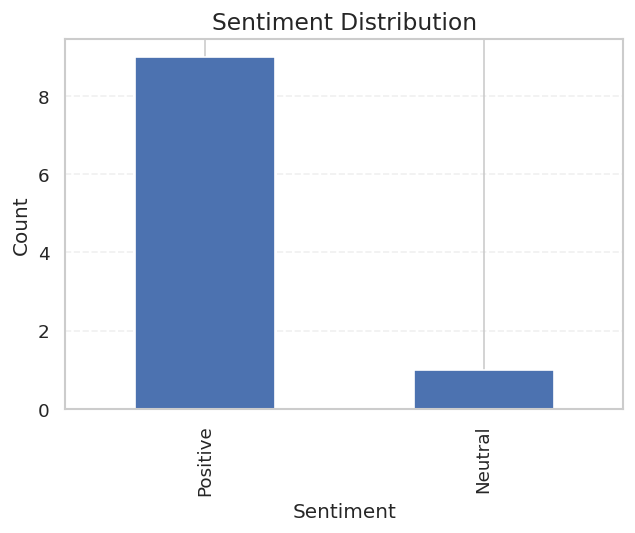

In [ ]:
# plt.figure(figsize=(6,4))
# sns.countplot(data=tweets_df, x="Sentiment", hue="Sentiment", palette="viridis", legend=False)
# plt.title(f"Sentiment Distribution for {company_name} Tweets")
# plt.xlabel("Sentiment")
# plt.ylabel("Tweet Count")
# plt.show()

plt.figure(figsize=(6,4))
sent_df['sentiment'].value_counts().plot(kind='bar', edgecolor='white')
plt.title("Sentiment Distribution", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()




## Step 9: Visualize Sentiment Trend Across Tweets
We create a **line chart** showing polarity trend across the 50 tweets.


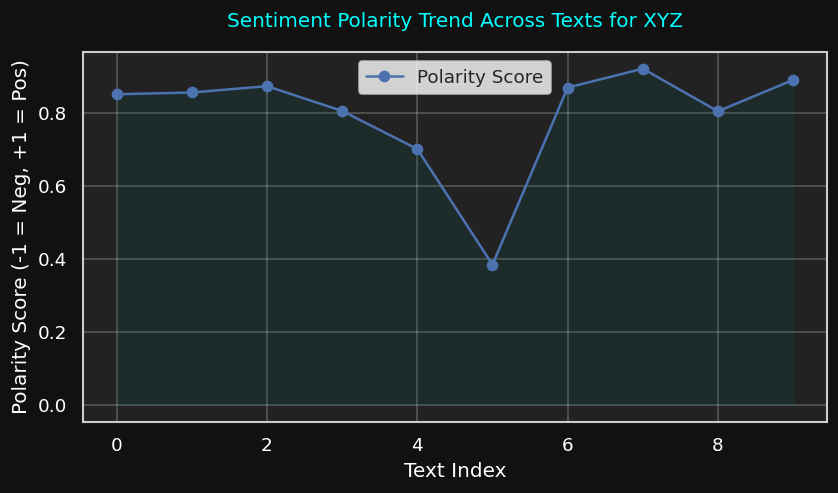

In [ ]:
# plt.figure(figsize=(8,4))
# plt.plot(tweets_df.index, tweets_df["Polarity"], marker='o', linestyle='-', color='teal')
# plt.title(f"Sentiment Polarity Trend Across Tweets for {company_name}")
# plt.xlabel("Tweet Index")
# plt.ylabel("Polarity Score")
# plt.grid(True)
# plt.show()

sent_df["polarity_score"] = (
    sent_df["pos"] * 1 + sent_df["neu"] * 0 + sent_df["neg"] * -1
)
# Plot polarity trend
plt.figure(figsize=(8, 4))
plt.plot(
    range(len(sent_df)),
    sent_df["polarity_score"],
    marker="o",
    linestyle="-",
    label="Polarity Score"
)
plt.fill_between(
    range(len(sent_df)),
    sent_df["polarity_score"],
    color="teal",
    alpha=0.1
)

plt.title(f"Sentiment Polarity Trend Across Texts for {company_name}", color="cyan", pad=15)
plt.xlabel("Text Index", color="white")
plt.ylabel("Polarity Score (-1 = Neg, +1 = Pos)", color="white")
plt.grid(True, alpha=0.3)
plt.legend()
plt.gcf().patch.set_facecolor("#111")
plt.gca().set_facecolor("#222")
plt.tick_params(colors="white")
plt.show()


## Step 10: Visualize Market Price Trend
For context, we visualize the closing price of the asset over the last 30 days.


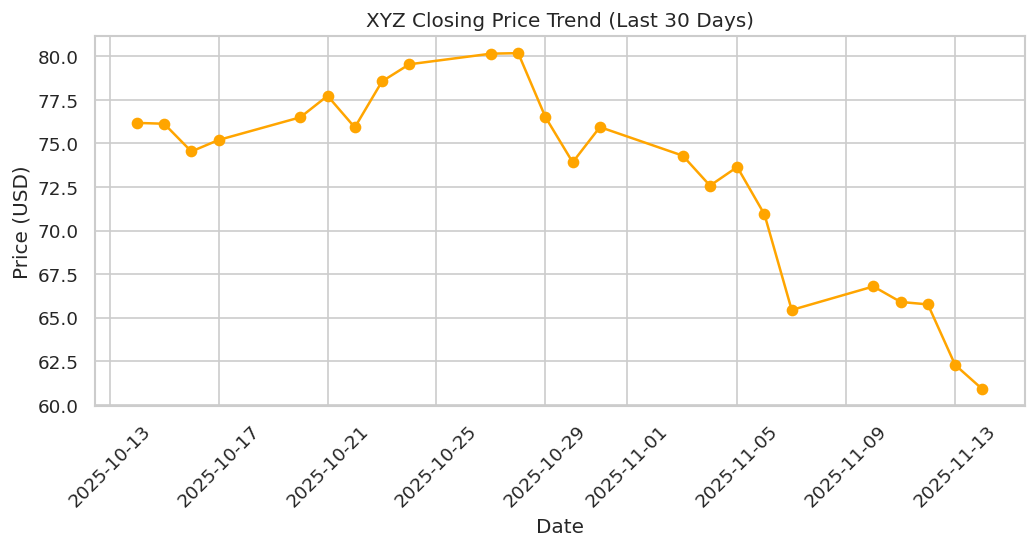

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(market_data["Date"], market_data["Close"], marker='o', color='orange')
plt.title(f"{company_name} Closing Price Trend (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Using Alpha Vantage for Stock Data


First, install the library:

In [ ]:
!pip install alpha_vantage

### Analyze Alpha Vantage Data
Here are some descriptive statistics for the Alpha Vantage data:

In [ ]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from google.colab import userdata

API_KEY = userdata.get('ALPHA_VANTAGE_API')
def detect_symbol(company_name: str) -> str:
    """
    Maps common company/asset names to their typical stock or crypto symbols.
    If no match is found, the name itself is returned as the potential symbol.
    """
    mapping = {
    "BITCOIN": "BTCUSD",
    "BTC": "BTCUSD",

    "TESLA": "TSLA",
    "TSLA": "TSLA",

    "NETFLIX": "NFLX",
    "NFLX": "NFLX",

    "INFOSYS": "INFY",
    "INFY": "INFY",

    "TCS": "TCS",
    "TATA CONSULTANCY": "TCS",

    "RAKUTEN": "RKUNY",

    # ✅ Common U.S. tech
    "APPLE": "AAPL",
    "AAPL": "AAPL",

    "GOOGLE": "GOOG",
    "ALPHABET": "GOOG",
    "GOOG": "GOOG",

    "MICROSOFT": "MSFT",
    "MSFT": "MSFT",

    "AMAZON": "AMZN",
    "AMZN": "AMZN",

    "NVIDIA": "NVDA",
    "NVDA": "NVDA",

    "META": "META",
    "FACEBOOK": "META",

    # ✅ More popular tickers
    "AMD": "AMD",
    "INTEL": "INTC",
    "COCA COLA": "KO",
    "PEPSICO": "PEP",
    "WALMART": "WMT",

    # ✅ Indian stocks (BSE/NSE)
    "RELIANCE": "RELIANCE.BSE",
    "HDFC": "HDFC.BSE",
    "ICICI": "ICICIBANK.BSE",
    "WIPRO": "WIPRO.BSE",
    "HCL": "HCLTECH.BSE",

    # ✅ Crypto
    "ETHEREUM": "ETHUSD",
    "ETH": "ETHUSD",
    "DOGE": "DOGEUSD",
    "DOGECOIN": "DOGEUSD",
    "SOLANA": "SOLUSD",
    "SOL": "SOLUSD",
}

    # Return the mapped symbol or the original name (converted to uppercase for robustness)
    return mapping.get(company_name.upper(), company_name.upper())

    # --- Core Trend Analysis Logic ---
def get_trend(df: pd.DataFrame) -> tuple[str, str]:
    """
    Calculates 20-day and 50-day Simple Moving Averages (SMA) to determine
    the market trend (Bullish, Bearish, or Sideways).
    The '4. close' column is used for calculations.
    """
    df = df.copy()

    # Check for minimum data requirement for a reliable 50-day SMA
    if len(df) < 50:
        return "⚠️ Insufficient Data", "Cannot calculate trend (needs at least 50 days of data)"

    # Calculate SMAs
    # Note: rolling() automatically aligns the mean to the end of the window
    df['SMA20'] = df['4. close'].rolling(window=20).mean()
    df['SMA50'] = df['4. close'].rolling(window=50).mean()

    # Get the latest calculated values
    latest = df.iloc[-1]

    # Handle potential NaN values (occurs if the window is not yet full)
    if pd.isna(latest['SMA20']) or pd.isna(latest['SMA50']):
         return "⚠️ Data Not Yet Complete", "Need more data points for rolling average calculation"

    # Compare SMAs (Golden Cross / Death Cross strategy)
    if latest['SMA20'] > latest['SMA50']:
        return "✅ Bullish Trend", "The short-term trend (SMA20) is above the long-term trend (SMA50). Potential Uptrend."
    elif latest['SMA20'] < latest['SMA50']:
        return "❌ Bearish Trend", "The short-term trend (SMA20) is below the long-term trend (SMA50). Potential Downtrend."
    else:
        return "↔️ Sideways Market", "SMAs are crossing or are too close. Neutral — Wait for a breakout."

# --- Main Execution Block ---
def run_analysis():
    """
    Main function to ask for user input, fetch data, and print the analysis.
    """
    if not API_KEY:
        print("\n❌ Error: ALPHA_VANTAGE_API_KEY is not configured.")
        print("Please set the 'ALPHA_VANTAGE_API_KEY' secret in your environment.")
        return

    # --- ASK USER ---
    try:
        # company_name = input("Enter the company name (e.g., Infosys, Rakuten, Netflix, TCS): ")
        company_name=company_name
    except EOFError:
        # Handle non-interactive environments by using a default
        company_name = "TESLA"
        print(f"Non-interactive environment detected. Using default company: {company_name}")


    if not company_name:
        print("Analysis cancelled: Company name cannot be empty.")
        return

    print(f"\nData analysis will be performed for: {company_name}")

    # --- SYMBOL DETECTION ---
    global symbol
    symbol = detect_symbol(company_name)
    print(f"Using symbol: {symbol}")

    # --- FETCH & PROCESS ---
    try:
        # Initialize the TimeSeries client
        # output_format='pandas' is essential for DataFrame operations
        ts = TimeSeries(key=API_KEY, output_format='pandas')
        global data
        # Fetch daily data (compact size fetches 100 data points, good for 50-day SMA)
        data, meta = ts.get_daily(symbol=symbol, outputsize='compact')
        # Alpha Vantage returns data newest-first, so sort the index (date) oldest-first
        data = data.sort_index()
        # print(data)

        print(f"\n📊 Latest Market Data for {company_name} ({symbol}):")
        # Display the last 3 days of data for review
        print(data[['4. close']].tail(3).to_markdown(numalign="left", stralign="left"))
        global trend, decision
        # Perform the trend analysis
        trend, decision = get_trend(data)

        # Output the results
        print("\n--- Analysis Result ---")
        print(f"Asset: {company_name} ({symbol})")
        print(f"📌 Trend Status: {trend}")
        print(f"🧾 Decision: {decision}")
        print("-----------------------")

    except ValueError as ve:
        # Alpha Vantage throws ValueError on invalid symbol or API key issues
        print(f"\n❌ Error fetching data for {company_name} ({symbol}):")
        print(f"    Details: {ve}")
        print("    Suggestion: Check if the symbol is correct and if the API key is valid.")

    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")

if __name__ == "__main__":
    run_analysis()


Data analysis will be performed for: XYZ
Using symbol: XYZ

📊 Latest Market Data for XYZ (XYZ):
| date                | 4. close   |
|:--------------------|:-----------|
| 2025-11-11 00:00:00 | 65.91      |
| 2025-11-12 00:00:00 | 65.77      |
| 2025-11-13 00:00:00 | 62.3       |

--- Analysis Result ---
Asset: XYZ (XYZ)
📌 Trend Status: ❌ Bearish Trend
🧾 Decision: The short-term trend (SMA20) is below the long-term trend (SMA50). Potential Downtrend.
-----------------------


Now, let's visualize the closing price over time:



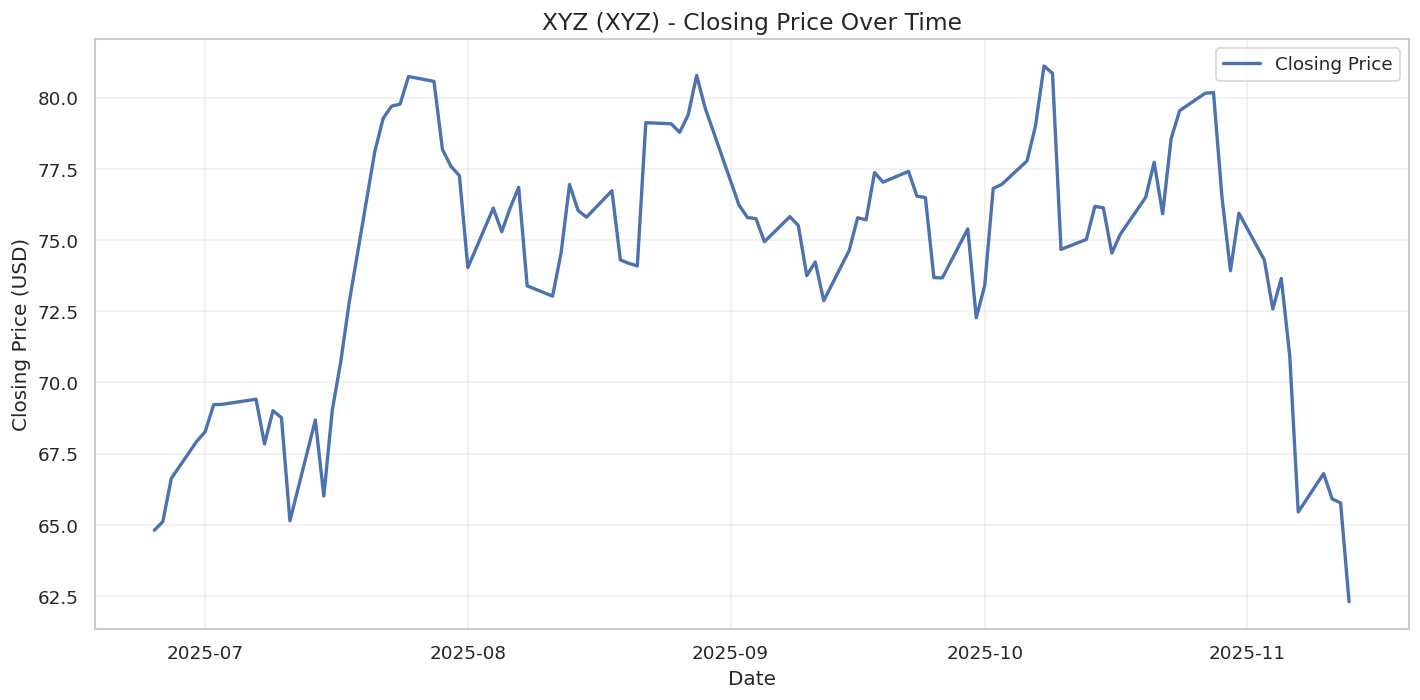

In [ ]:
# Ensure data exists
if 'data' in locals() and not data.empty:
  plt.figure(figsize=(12,6))
  plt.plot(data.index, data['4. close'], label='Closing Price', linewidth=2)

  plt.title(f"{company_name} ({symbol}) - Closing Price Over Time", fontsize=14)
  plt.xlabel("Date", fontsize=12)
  plt.ylabel("Closing Price (USD)", fontsize=12)
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()
else:
    print("No data available to visualize. Please run the data fetch cell first.")

In [ ]:
import plotly.graph_objects as go
# Ensure data is available
if 'data' in locals() and not data.empty:
    fig = go.Figure(data=[
        go.Candlestick(
            x=data.index,
            open=data['1. open'],
            high=data['2. high'],
            low=data['3. low'],
            close=data['4. close'],
            name=f"{company_name}"
        )
    ])

    fig.update_layout(
        title=f"{company_name} ({symbol}) - Candlestick Chart",
        xaxis_title="Date",
        yaxis_title="Price (USD)",
        xaxis_rangeslider_visible=False,
        template="plotly_white",
        width=950,
        height=550
    )

    fig.show()
else:
    print("No data available to visualize. Please run the data fetch cell first.")


# Sprint 1 Conclusion
**What we achieved in Sprint 1:**

1. Collected real-time open-source data from:


* Wikipedia (summary)
* Yahoo Finance (market prices)
* Google News RSS (recent headlines)
* Generated synthetic tweets (50) for sentiment analysis

2. Cleaned and structured data using **pandas DataFrames**
3. Performed sentiment analysis using **TextBlob**

4. Visualized key insights:
* Sentiment distribution (bar chart)
* Sentiment trend across tweets (line chart)
* Market price trend (line chart)

5. Built a flexible, interactive notebook for any asset/company input

This notebook sets the foundation for Sprint 2, where we will integrate real-time dashboards and AI-driven analytics.

In [ ]:
import numpy as np
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def card(title, content):
    html = f"""
    <div style='border:1px solid #ddd;border-radius:10px;padding:15px;margin:10px;
                background:beige;font-family:sans-serif;color:black;'>
        <h3 style='text-align:center; color:black'>{title}</h3>
        <p style='line-height:1.5; font-color:white;'>{content}</p>
    </div>
    """
    display(HTML(html))


Headline,Link
"BTIG Reiterates Buy Rating for XYZ, Price Target Maintained | XY - GuruFocus",Read More
"Prospera Financial Services Inc Takes $970,000 Position in Block, Inc. $XYZ - MarketBeat",Read More
Analysts Offer Insights on Technology Companies: Block (XYZ) and Micron (MU) - The Globe and Mail,Read More
Will XYZ stock profit from fiscal stimulus - Insider Selling & Weekly Consistent Profit Watchlists - Fundação Cultural do Pará,Read More
TD Cowen: 'Unveiling the Next Evolution of Block Inc. (XYZ)' - StreetInsider,Read More
Why Block (XYZ) Shares Are Tumbling Today? - Yahoo Finance,Read More
"Notable Thursday Option Activity: XYZ, FSLR, IRM - Nasdaq",Read More
"Block (blockstreet.xyz) price today, BLOCK to USD live price, marketcap and chart - CoinMarketCap",Read More
"Stablecoin network Stable.xyz, backed by PayPal Ventures, develops infrastructure for cross-border payments - xyz Domain Names",Read More
Time To Buy XYZ Stock? - Forbes,Read More


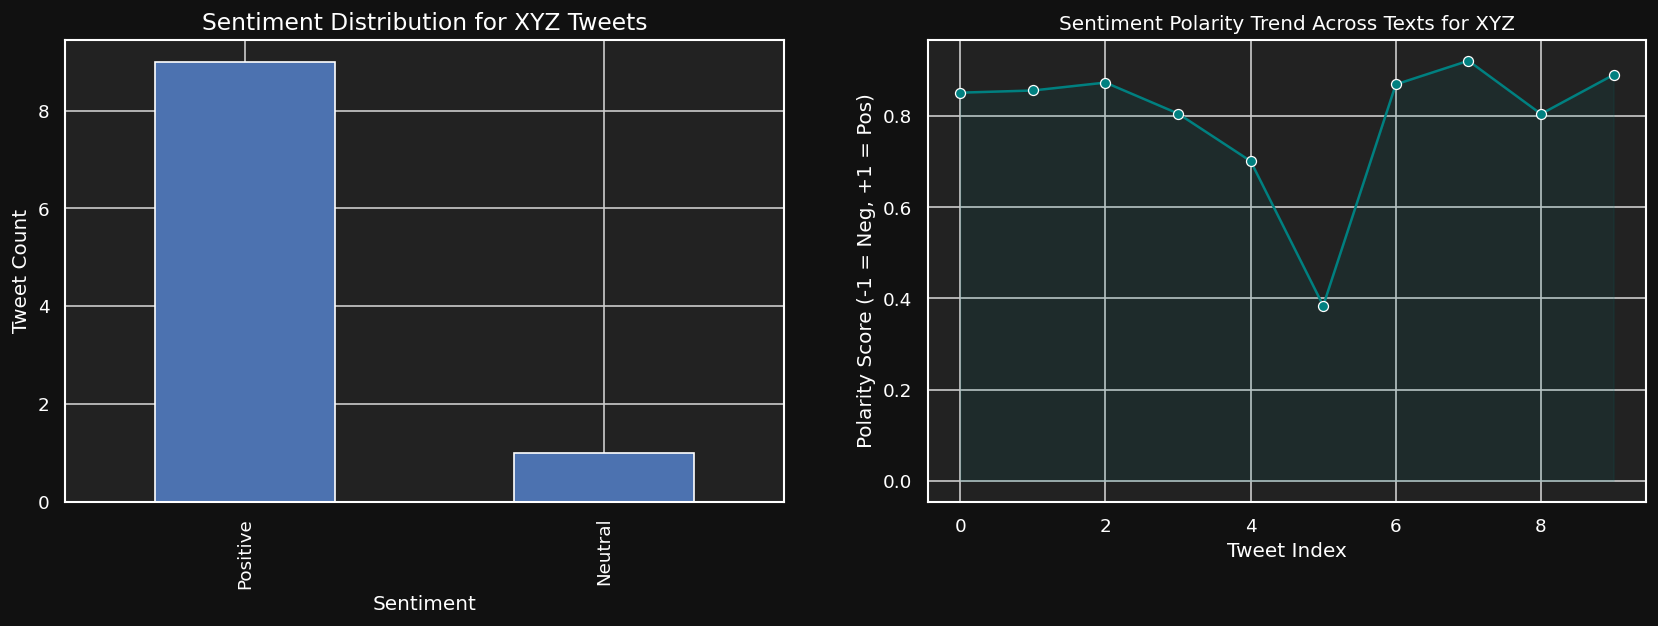

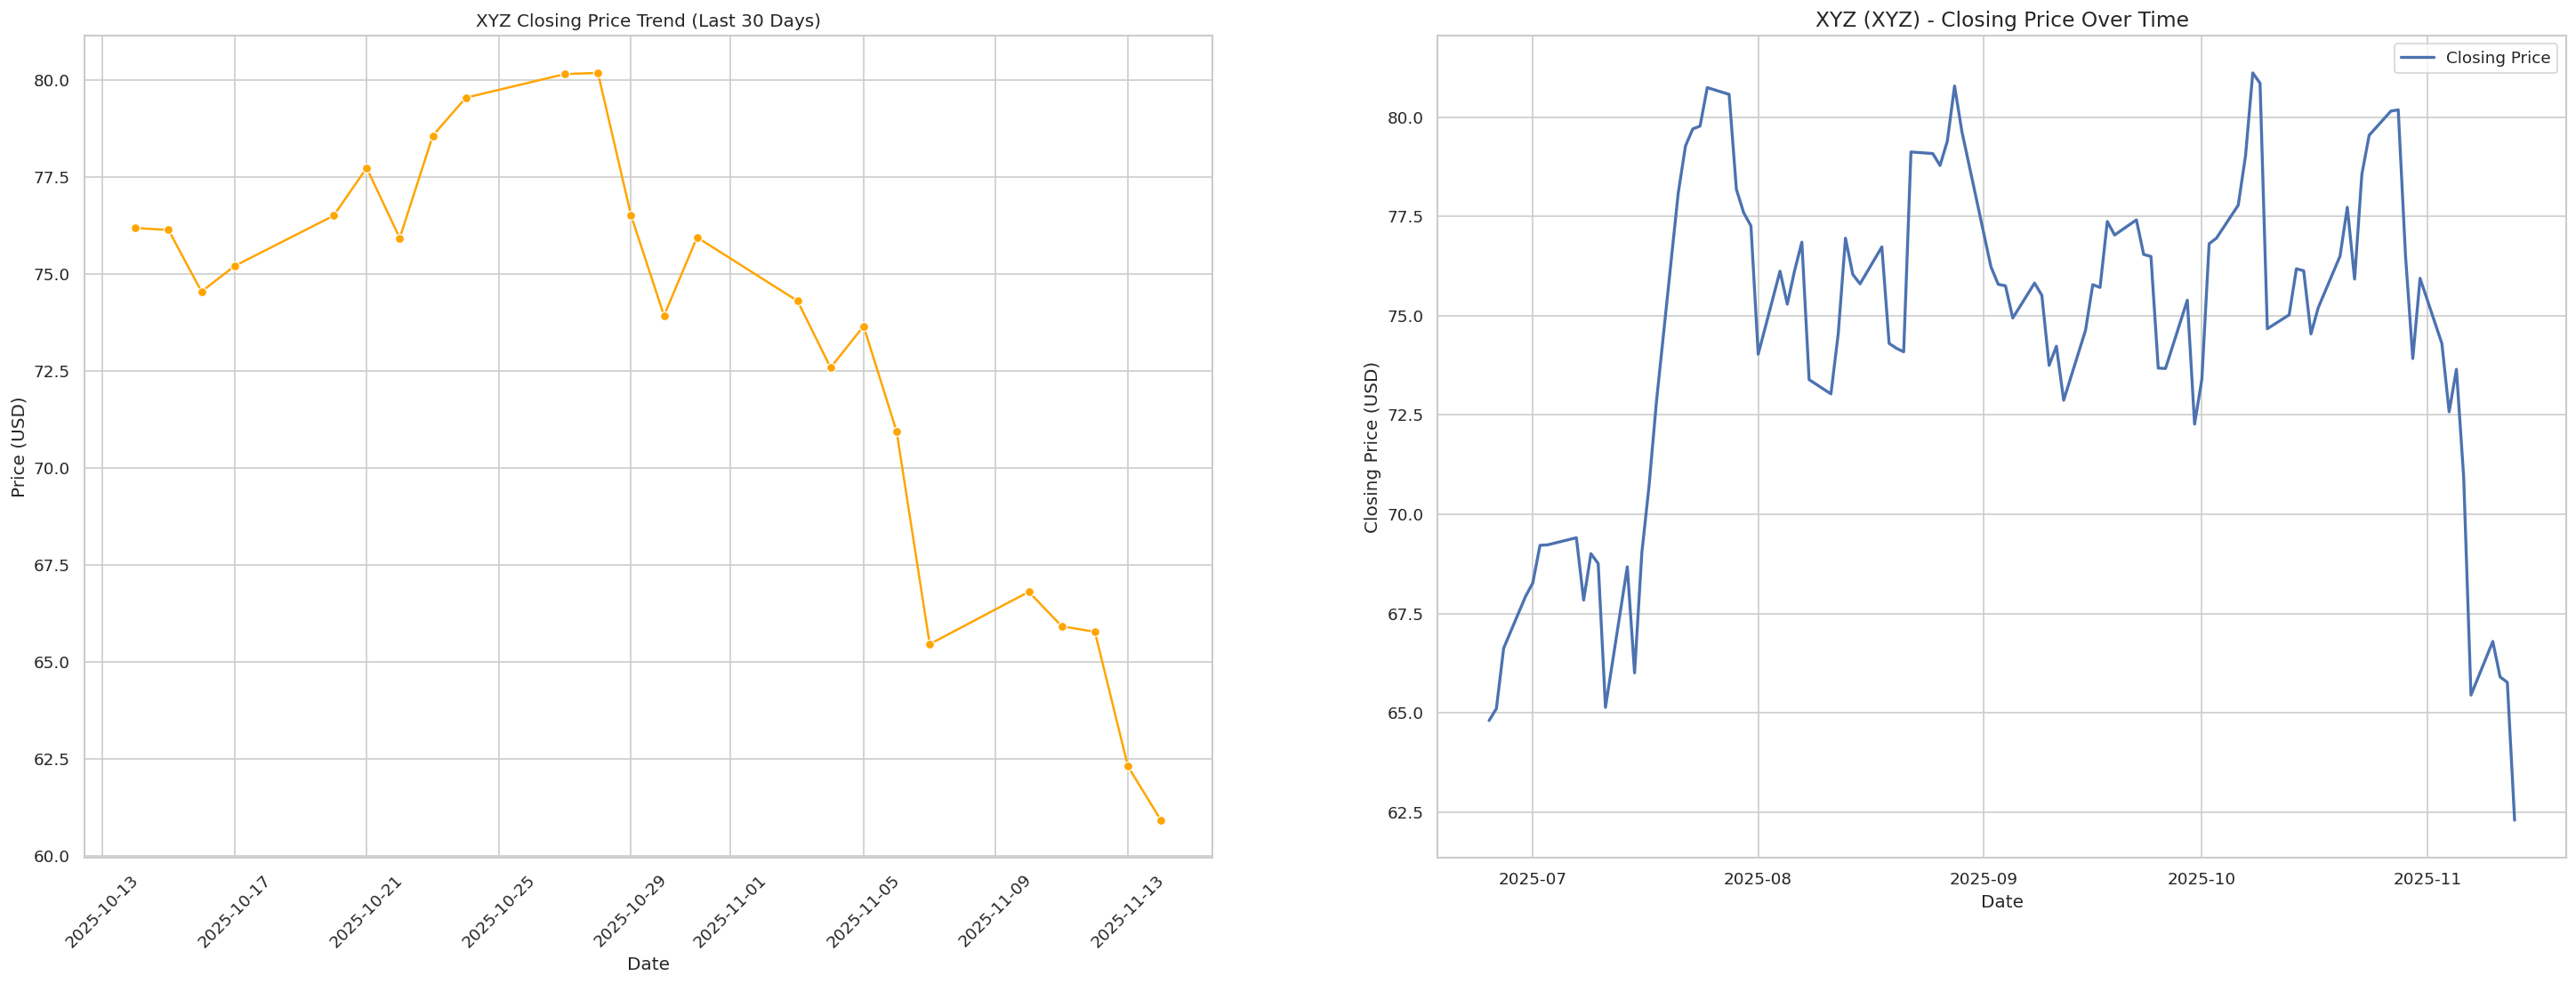

In [ ]:
def dashboard(company, summary, analysis_trend, analysis_decision):
  card(company, summary)
  display(HTML(f"<h2 style='font-size:28px; margin-top:25px;'>Top 10 News Headlines for {company}:</h2>"))
  # Remove quotes around titles
  cleaned_titles = [t.strip("'\"") for t in titles]

  # Create a table
  df = pd.DataFrame({
      "Headline": cleaned_titles,
      "Link": [f'<a href="{l}" target="_blank">Read More</a>' for l in links]
  })

  display(HTML(df.to_html(escape=False, index=False)))

  fig, ax = plt.subplots(1,2, figsize=(17,5))

  # sns.countplot(data=tweets_df, x="Sentiment", hue="Sentiment", palette="viridis", legend=False, ax=ax[0])
  # if news_items:
  sent_df['sentiment'].value_counts().plot(kind='bar', edgecolor='white', ax=ax[0])
  ax[0].set_title(f"Sentiment Distribution for {company} Tweets", fontsize=14, color="white")
  ax[0].set_xlabel("Sentiment", color="white")
  ax[0].set_ylabel("Tweet Count", color="white")


  plt.fill_between(
    range(len(sent_df)),
    sent_df["polarity_score"],
    color="teal",
    alpha=0.1
  )
  sns.lineplot(x=sent_df.index, y=sent_df["polarity_score"], marker='o', linestyle='-', color='teal', ax=ax[1])
  ax[1].set_title(f"Sentiment Polarity Trend Across Texts for {company_name}", color="white")
  ax[1].set_xlabel("Tweet Index",  color="white")
  ax[1].set_ylabel("Polarity Score (-1 = Neg, +1 = Pos)",  color="white")
  ax[1].grid(True)

  # --- Apply dark theme to background and all text elements ---
  for a in ax:
      a.set_facecolor("#222")  # axis background
      a.tick_params(colors="white")  # tick label colors
      for spine in a.spines.values():  # axis borders
          spine.set_color("white")

  # --- Figure background ---
  fig.patch.set_facecolor("#111")
  plt.show()

  analysis_text = f"""
  <div style='font-size:15px;'>
    📌 Asset: {company} ({symbol})<br>
    📈 Trend Status: {analysis_trend}<br>
    ✅ Decision: {analysis_decision}
    </div>
    """

  card("AI analysis Summary", analysis_text)



  fig, ax = plt.subplots(1,2, figsize=(30,10))

  sns.lineplot(x=market_data["Date"], y=market_data["Close"], marker='o', color='orange', ax=ax[0])
  ax[0].set_title(f"{company_name} Closing Price Trend (Last 30 Days)")
  ax[0].set_xlabel("Date")
  ax[0].set_ylabel("Price (USD)")
  ax[0].tick_params(axis='x', rotation=45)


  sns.lineplot(x=data.index, y=data['4. close'], label='Closing Price', linewidth=2, ax=ax[1])
  ax[1].set_title(f"{company_name} ({symbol}) - Closing Price Over Time", fontsize=14)
  ax[1].set_xlabel("Date", fontsize=12)
  ax[1].set_ylabel("Closing Price (USD)", fontsize=12)
  plt.grid(True)
  plt.show()

dashboard(company=company_name, summary=company_summary, analysis_trend=trend, analysis_decision=decision)

# **Slack Alerts Sender**

In [ ]:
# ✅ Slack Alert Sender

import os, json, requests
from datetime import datetime

# ✅ Store your real webhook here for local testing
# (In Colab use: os.environ["SLACK_WEBHOOK_URL"] = userdata.get("SLACK_WEBHOOK_URL"))
SLACK_WEBHOOK_URL = userdata.get("SLACK_WEBHOOK_URL")
def send_slack_alert(data):
    webhook = SLACK_WEBHOOK_URL
    if not webhook:
        print("❌ Slack webhook missing.")
        return

    # ✅ Slack requires at least a "text" field
    payload = {
        "text": f"🚨 {data['alert_type']} for {data['company_name']} ({data['company_ticker']})",
        "blocks": [
            {
                "type": "header",
                "text": {
                    "type": "plain_text",
                    "text": f"{data['alert_type']} — {data['company_ticker']}"
                }
            },
            {
                "type": "section",
                "fields": [
                    {"type": "mrkdwn", "text": f"*Company:*\n{data['company_name']}"},
                    {"type": "mrkdwn", "text": f"*Ticker:*\n{data['company_ticker']}"},
                    # {"type": "mrkdwn", "text": f"*Price:*\n${data['current_price']:.2f}"},
                    {"type": "mrkdwn", "text": f"*Sentiment:*\n{data['sentiment_score']:.2f}"},
                    # {"type": "mrkdwn", "text": f"*Daily Change:*\n{data['daily_change_percent']:.2f}%"},
                    {"type": "mrkdwn", "text": f"*Volatility:*\n{data['volatility_metric']}"},
                ]
            },
            {"type": "divider"},
            {
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"*Recommendation:*\n{data['strategic_action']}"
                }
            },
            {
                "type": "context",
                "elements": [
                    {"type": "mrkdwn", "text": f"Signal Time: {data['signal_time']}"}
                ]
            }
        ]
    }

    r = requests.post(
        webhook,
        data=json.dumps(payload),
        headers={"Content-Type": "application/json"}
    )

    if r.status_code == 200:
        print("✅ Slack alert sent successfully!")
    else:
        print("❌ Slack Error:", r.text)
def build_alert(company, ticker, title, body, sentiment):
    return {
        "company_name": company,
        "company_ticker": ticker,
        "alert_type": title,
        "strategic_action": body,
        # "current_price": price,
        "sentiment_score": sentiment,
        # "daily_change_percent": change,
        # "daily_change_absolute": round(price * (change / 100), 2),
        "volatility_metric": "Medium",
        "signal_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }


In [ ]:
# day_change = ((df.y.iloc[-1] - df.y.iloc[-2]) / df.y.iloc[-2]) * 100
pos_ratio = (sent_df["sentiment"] == "Positive").mean()
neg_ratio = (sent_df["sentiment"] == "Negative").mean()

if pos_ratio > 0.60:
    alert = build_alert(
        company=company_name,
        ticker=symbol,
        title="📈 Bullish Sentiment Detected",
        body=f"{company_name} shows strong positive sentiment ({pos_ratio*100:.1f}%).",
        # price=float(df.y.iloc[-1]),
        sentiment=float(pos_ratio),
        # change=float(day_change)
    )
    send_slack_alert(alert)
elif neg_ratio > 0.60:
    alert = build_alert(
        company=company_name,
        ticker=symbol,
        title="📉 Bearish Sentiment Detected",
        body=f"{company_name} shows strong *negative* sentiment ({neg_ratio*100:.1f}%). "
             f"Consider risk management or hedging strategies.",
        # price=float(df.y.iloc[-1]),
        sentiment=float(-neg_ratio),  # negative for clarity if you want
        # change=float(day_change)
    )
    send_slack_alert(alert)
else:
    print("No Slack alert triggered.")


✅ Slack alert sent successfully!
